# LangGraph를 이용한 Self-RAG (Self-Reflective Retrieval-Augmented Generation)

## 1. Self-RAG 개요
- Self-RAG는 기존 RAG 시스템에 **자체 평가(Self-Reflection)** 메커니즘을 추가한 고급 RAG 시스템입니다. 
    - 이 시스템은 검색의 필요성을 판단하고, 검색된 문서의 관련성을 평가하며, 생성된 답변의 품질을 자체적으로 검증합니다.
- Self-RAG는 기존 RAG 시스템의 한계를 극복하고, 더욱 지능적이고 신뢰할 수 있는 질의응답 시스템을 구현할 수 있게 해줍니다. 

### 1.1 기존 RAG vs Self-RAG

| 구분 | 기존 RAG | Self-RAG |
|------|----------|----------|
| 검색 | 항상 검색 수행 | 필요시에만 검색 |
| 평가 | 없음 | 검색 결과 관련성 평가 |
| 생성 | 단순 생성 | 자체 평가 후 생성 |
| 품질 관리 | 없음 | 답변 품질 자체 검증 |
| 출처 표시 | 선택적 | 필수적 |

### 1.2 Corrective RAG vs Self-RAG
| 구분 | Corrective RAG | Self RAG |
|------|----------------|----------|
| **초점** | 검색된 문서 품질 교정 | 생성된 답변 자체 검증 |
| **개입 시점** | 문서 검색 후, 답변 생성 전 | 답변 생성 후 |
| **평가 대상** | 검색 문서의 관련성 | 생성된 답변의 정확성 |
| **교정 방법** | 문서 재검색, 재작성 | 답변 재생성, 수정 |

### 1.2 Self-RAG의 핵심 구성 요소

1. **Retrieve Token**: 검색이 필요한지 판단
2. **Relevance Token**: 검색된 문서의 관련성 평가  
3. **Support Token**: 답변이 검색 결과로 뒷받침되는지 평가
4. **Utility Token**: 최종 답변의 유용성 평가

### 1.3 Self-RAG 워크플로우

```
질문 입력 → 검색 필요성 판단 → 문서 검색 → 관련성 평가 → 답변 생성 → 품질 검증 → 최종 답변
```

## 2. 환경 설정 및 라이브러리 설치

먼저 필요한 라이브러리들을 설치하고 환경을 설정합니다.


In [1]:
# 필요한 라이브러리 임포트
import os
from typing import List, Dict, Any, Optional, TypedDict
from dotenv import load_dotenv

# LangChain 관련
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ChromaDB
import chromadb
from chromadb.config import Settings

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

# 기타
import pandas as pd
from tqdm import tqdm

# 환경 변수 로드
load_dotenv()

print("라이브러리 임포트 완료!")


라이브러리 임포트 완료!


### API 키 설정
- [OpenAI API 키](https://platform.openai.com/api-keys)

In [ ]:
import os

# API 키 설정
os.environ["OPENAI_API_KEY"] = "sk-proj-examplekey1234567890"

# API 키 확인
openai_key = os.getenv("OPENAI_API_KEY")

if openai_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)


## 3. LangGraph State 정의

Self-RAG 시스템의 상태를 관리하기 위한 State 클래스를 정의합니다.


In [3]:
class SelfRAGState(TypedDict):
    """Self-RAG 시스템의 상태를 정의하는 클래스"""
    
    # 입력 정보
    question: str  # 사용자 질문
    
    # 검색 관련
    need_retrieval: bool  # 검색 필요 여부
    retrieved_docs: List[Document]  # 검색된 문서들
    relevant_docs: List[Document]  # 관련성이 있는 문서들
    
    # 답변 생성 관련
    answer: str  # 생성된 답변
    sources: List[str]  # 출처 정보
    
    # 평가 관련
    relevance_score: float  # 관련성 점수
    support_score: float  # 지지도 점수
    utility_score: float  # 유용성 점수
    
    # 최종 결과
    final_answer: str  # 최종 답변 (출처 포함)
    confidence: str  # 신뢰도 ("high", "medium", "low", "unknown")

print("SelfRAGState 클래스 정의 완료!")


SelfRAGState 클래스 정의 완료!


## 4. ChromaDB 벡터스토어 설정 및 데이터 로딩

ChromaDB를 설정하고 data 폴더의 파일을 로딩하는 함수들을 구현합니다.


### ChromaDB 벡터스토어를 설정하는 함수

In [ ]:
def setup_vectorstore():
    """ChromaDB 벡터스토어를 설정하는 함수"""
    
    # ChromaDB 클라이언트 생성
    client = chromadb.PersistentClient(path="./chroma_db")
    
    # 컬렉션 생성 또는 가져오기
    try:
        collection = client.get_collection("rag_keywords")
        print("기존 컬렉션을 불러왔습니다.")
    except:
        collection = client.create_collection("rag_keywords")
        print("새 컬렉션을 생성했습니다.")
    
    return client, collection

### 데이터 파일을 로드하고 처리하는 함수

In [ ]:
def load_and_process_data(file_path: str = "./data/rag-keywords.txt"):
    """데이터 파일을 로드하고 처리하는 함수"""
    
    documents = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        
        # 각 키워드별로 분리
        sections = content.split('\n\n')
        
        for section in sections:
            if section.strip():
                lines = section.strip().split('\n')
                if len(lines) >= 2:
                    keyword = lines[0].strip()
                    definition = '\n'.join(lines[1:]).strip()
                    
                    # Document 객체 생성
                    doc = Document(
                        page_content=f"키워드: {keyword}\n{definition}",
                        metadata={
                            "keyword": keyword,
                            "source": file_path,
                            "type": "definition"
                        }
                    )
                    documents.append(doc)
        
        print(f"총 {len(documents)}개의 문서를 로드했습니다.")
        return documents
        
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")
        return []
    except Exception as e:
        print(f"데이터 로딩 중 오류 발생: {e}")
        return []

### 문서들을 임베딩하여 벡터스토어에 저장하는 함수

In [ ]:
def create_embeddings_and_store(documents: List[Document], collection):
    """문서들을 임베딩하여 벡터스토어에 저장하는 함수"""
    
    if not documents:
        print("저장할 문서가 없습니다.")
        return
    
    # OpenAI 임베딩 모델 초기화
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    
    # 기존 데이터 확인
    existing_count = collection.count()
    if existing_count > 0:
        print(f"이미 {existing_count}개의 문서가 저장되어 있습니다.")
        return
    
    print("문서들을 임베딩하고 저장하는 중...")
    
    # 배치 처리를 위한 준비
    batch_size = 10
    
    for i in tqdm(range(0, len(documents), batch_size)):
        batch_docs = documents[i:i+batch_size]
        
        # 텍스트와 메타데이터 추출
        texts = [doc.page_content for doc in batch_docs]
        metadatas = [doc.metadata for doc in batch_docs]
        ids = [f"doc_{i+j}" for j in range(len(batch_docs))]
        
        # 임베딩 생성
        embeddings_vectors = embeddings.embed_documents(texts)
        
        # ChromaDB에 저장
        collection.add(
            embeddings=embeddings_vectors,
            documents=texts,
            metadatas=metadatas,
            ids=ids
        )
    
    print(f"총 {len(documents)}개의 문서가 벡터스토어에 저장되었습니다.")

### 벡터스토어 설정 및 데이터 로딩 실행

In [ ]:
client, collection = setup_vectorstore()
documents = load_and_process_data()
create_embeddings_and_store(documents, collection)


기존 컬렉션을 불러왔습니다.
총 30개의 문서를 로드했습니다.
이미 30개의 문서가 저장되어 있습니다.


## 5. Self-RAG 핵심 함수들 구현

Self-RAG의 각 단계를 처리하는 함수들을 구현합니다.


### LLM 모델 초기화

In [ ]:

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


### Embedding Model 초기화 

In [ ]:

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


### 검색이 필요한지 판단하는 함수

In [ ]:
def decide_retrieval(state: SelfRAGState) -> SelfRAGState:
    """검색이 필요한지 판단하는 함수"""
    
    question = state["question"]
    
    # 검색 필요성 판단 프롬프트
    retrieval_prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """
        당신은 질문을 분석하여 외부 지식이 필요한지 판단하는 전문가입니다.

            다음 기준으로 판단하세요:
            - 일반적인 인사말이나 간단한 질문: 검색 불필요
            - 특정 기술, 개념, 정의에 대한 질문: 검색 필요
            - 복잡한 설명이나 전문 지식이 필요한 질문: 검색 필요

        'YES' 또는 'NO'로만 답변하세요."""),
        ("human", "질문: {question}")
    ])
    
    chain = retrieval_prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question})
    
    need_retrieval = result.strip().upper() == "YES"
    
    print(f"검색 필요성 판단: {'필요' if need_retrieval else '불필요'}")
    
    return {
        **state,
        "need_retrieval": need_retrieval
    }


### 문서를 검색하는 함수

In [ ]:
def retrieve_documents(state: SelfRAGState) -> SelfRAGState:
    """문서를 검색하는 함수"""
    
    if not state["need_retrieval"]:
        print("검색이 필요하지 않아 건너뜁니다.")
        return {
            **state,
            "retrieved_docs": []
        }
    
    question = state["question"]
    
    # 질문을 임베딩으로 변환
    query_embedding = embeddings.embed_query(question)
    
    # ChromaDB에서 유사한 문서 검색
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=5,
        include=["documents", "metadatas", "distances"]
    )
    
    # Document 객체로 변환
    retrieved_docs = []
    if results["documents"] and results["documents"][0]:
        for i, (doc, metadata) in enumerate(zip(results["documents"][0], results["metadatas"][0])):
            retrieved_docs.append(Document(
                page_content=doc,
                metadata={
                    **metadata,
                    "similarity_score": 1 - results["distances"][0][i]  # 거리를 유사도로 변환
                }
            ))
    
    print(f"{len(retrieved_docs)}개의 문서를 검색했습니다.")
    
    return {
        **state,
        "retrieved_docs": retrieved_docs
    }

### 검색된 문서의 관련성을 평가하는 함수

In [ ]:
def evaluate_relevance(state: SelfRAGState) -> SelfRAGState:
    """검색된 문서의 관련성을 평가하는 함수"""
    
    retrieved_docs = state["retrieved_docs"]
    
    if not retrieved_docs:
        print("검색된 문서가 없어 관련성 평가를 건너뜁니다.")
        return {
            **state,
            "relevant_docs": [],
            "relevance_score": 0.0
        }
    
    question = state["question"]
    relevant_docs = []
    relevance_scores = []
    
    # 관련성 평가 프롬프트
    relevance_prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """
        당신은 문서의 관련성을 평가하는 전문가입니다.

        주어진 질문과 문서가 얼마나 관련이 있는지 평가하세요.
        - 매우 관련있음: 5점
        - 관련있음: 4점  
        - 보통: 3점
        - 약간 관련있음: 2점
        - 관련없음: 1점

        점수만 숫자로 답변하세요 (1-5)."""),
        ("human", "질문: {question}\n\n문서: {document}")
    ])
    
    chain = relevance_prompt | llm | StrOutputParser()
    
    for doc in retrieved_docs:
        try:
            score_str = chain.invoke({
                "question": question,
                "document": doc.page_content
            })
            score = float(score_str.strip())
            
            if score >= 3.0:  # 3점 이상만 관련 문서로 간주
                relevant_docs.append(doc)
                relevance_scores.append(score)
                
        except ValueError:
            print(f"점수 파싱 오류: {score_str}")
            continue
    
    avg_relevance = sum(relevance_scores) / len(relevance_scores) if relevance_scores else 0.0
    
    print(f"{len(relevant_docs)}개의 관련 문서를 선별했습니다. (평균 관련성: {avg_relevance:.2f})")
    
    return {
        **state,
        "relevant_docs": relevant_docs,
        "relevance_score": avg_relevance
    }

Self-RAG 핵심 함수들 구현 완료!


### 답변을 생성하고 출처를 표시하는 함수

In [ ]:
def __generate_answer_of_no_relevant_docs(state: SelfRAGState) -> SelfRAGState:
    # 관련 문서가 없는 경우
    print("관련 문서가 없어 일반적인 답변을 생성합니다.")
    
    general_prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """
        당신은 도움이 되는 AI 어시스턴트입니다.

        주어진 질문에 대해 다음 규칙을 따르세요:
        1. 일반적인 인사말이나 간단한 대화는 친근하게 답변하세요.
        2. 전문적인 기술 용어나 복잡한 개념에 대한 질문이라면 "죄송하지만 해당 질문에 대한 정확한 정보를 제공할 수 없습니다"라고 답변하세요.
        3. 확실하지 않은 내용은 추측하지 마세요."""),
        ("human", "질문: {question}")
    ])
    
    chain = general_prompt | llm | StrOutputParser()
    answer = chain.invoke({"question": state["question"]})
    
    return {
        **state,
        "answer": answer,
        "sources": [],
        "confidence": "low"
    }

In [ ]:
def __generate_answer_of_relevant_docs(state: SelfRAGState) -> SelfRAGState:
    question = state["question"]
    relevant_docs = state["relevant_docs"]
    
    # 관련 문서가 있는 경우
    context = "\n\n".join([
        f"문서 {i+1}: {doc.page_content}" 
        for i, doc in enumerate(relevant_docs)
    ])
    
    # 답변 생성 프롬프트
    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """
        당신은 주어진 문서를 바탕으로 정확한 답변을 제공하는 전문가입니다.

        다음 규칙을 따르세요:
        1. 주어진 문서의 내용만을 바탕으로 답변하세요
        2. 문서에 없는 내용은 추측하지 마세요
        3. 답변은 명확하고 구체적으로 작성하세요
        4. 한국어로 답변하세요"""),
        ("human", 
        """
        질문: {question}

        참고 문서:
        {context}

        위 문서를 바탕으로 질문에 답변해주세요.""")
    ])
    
    chain = answer_prompt | llm | StrOutputParser()
    answer = chain.invoke({
        "question": question,
        "context": context
    })
    
    # 출처 정보 생성 (파일명으로 표시)
    sources = []
    for doc in relevant_docs:
        source_path = doc.metadata.get("source", "알 수 없음")
        # 파일 경로에서 파일명만 추출
        filename = source_path.split("/")[-1] if "/" in source_path else source_path
        sources.append(f"파일: {filename}")
    
    print(f"답변 생성 완료. 출처: {len(sources)}개")
    
    return {
        **state,
        "answer": answer,
        "sources": sources,
        "confidence": "high" if len(relevant_docs) >= 2 else "medium"
    }

In [ ]:
def generate_answer(state: SelfRAGState) -> SelfRAGState:
    """답변을 생성하고 출처를 표시하는 함수"""
    
    if not state["relevant_docs"]:
        return __generate_answer_of_no_relevant_docs(state)
    
    return __generate_answer_of_relevant_docs(state)

### 답변이 검색 결과로 뒷받침되는지 평가하는 함수

In [ ]:
def evaluate_support(state: SelfRAGState) -> SelfRAGState:
    """답변이 검색 결과로 뒷받침되는지 평가하는 함수"""
    
    answer = state["answer"]
    relevant_docs = state["relevant_docs"]
    
    if not relevant_docs:
        return {
            **state,
            "support_score": 0.0
        }
    
    context = "\n".join([doc.page_content for doc in relevant_docs])
    
    # 지지도 평가 프롬프트
    support_prompt = ChatPromptTemplate.from_messages([
        ("system", 
        """
        당신은 답변이 주어진 문서로 얼마나 뒷받침되는지 평가하는 전문가입니다.

        다음 기준으로 평가하세요:
        - 완전히 뒷받침됨: 5점
        - 대부분 뒷받침됨: 4점
        - 부분적으로 뒷받침됨: 3점
        - 약간 뒷받침됨: 2점
        - 뒷받침되지 않음: 1점

        점수만 숫자로 답변하세요 (1-5)."""),
        ("human", "답변: {answer}\n\n참고 문서: {context}")
    ])
    
    chain = support_prompt | llm | StrOutputParser()
    
    try:
        score_str = chain.invoke({
            "answer": answer,
            "context": context
        })
        support_score = float(score_str.strip())
    except ValueError:
        support_score = 3.0  # 기본값
    
    print(f"지지도 평가: {support_score}/5")
    
    return {
        **state,
        "support_score": support_score
    }

### 최종 답변을 생성하는 함수 (출처 포함)

In [ ]:
def create_final_answer(state: SelfRAGState) -> SelfRAGState:
    """최종 답변을 생성하는 함수 (출처 포함)"""
    
    answer = state["answer"]
    sources = state["sources"]
    confidence = state["confidence"]
    
    # 신뢰도가 낮거나 출처가 없는 경우
    if confidence == "low" or not sources:
        if "정확한 정보를 제공할 수 없습니다" in answer or "모르겠습니다" in answer:
            final_answer = "죄송하지만 해당 질문에 대한 정확한 정보를 제공할 수 없습니다."
        else:
            final_answer = answer
        
        return {
            **state,
            "final_answer": final_answer,
            "confidence": "unknown"
        }
    
    # 출처가 있는 경우 출처 정보 추가
    final_answer = answer + "\n\n**출처:**\n"
    for i, source in enumerate(sources, 1):
        final_answer += f"{i}. {source}\n"
    
    print("최종 답변 생성 완료")
    
    return {
        **state,
        "final_answer": final_answer
    }


답변 생성 및 출처 표시 함수들 구현 완료!


## 6. LangGraph 워크플로우 구성

Self-RAG 시스템의 전체 워크플로우를 LangGraph로 구성합니다.


### 검색 필요성에 따라 다음 단계를 결정하는 조건부 함수

In [ ]:
def should_retrieve(state: SelfRAGState) -> str:
    """검색 필요성에 따라 다음 단계를 결정하는 조건부 함수"""
    if state["need_retrieval"]:
        return "retrieve"
    else:
        return "generate"

### Self-RAG 워크플로우를 생성하는 함수

In [ ]:
def create_self_rag_workflow():
    """Self-RAG 워크플로우를 생성하는 함수"""
    
    # StateGraph 생성
    workflow = StateGraph(SelfRAGState)
    
    # 노드 추가
    workflow.add_node("decide_retrieval", decide_retrieval)
    workflow.add_node("retrieve", retrieve_documents)
    workflow.add_node("evaluate_relevance", evaluate_relevance)
    workflow.add_node("generate", generate_answer)
    workflow.add_node("evaluate_support", evaluate_support)
    workflow.add_node("create_final", create_final_answer)
    
    # 엣지 추가
    workflow.set_entry_point("decide_retrieval")
    
    # 조건부 엣지: 검색 필요성에 따라 분기
    workflow.add_conditional_edges(
        "decide_retrieval",
        should_retrieve,
        {
            "retrieve": "retrieve",
            "generate": "generate"
        }
    )
    
    # 검색 경로
    workflow.add_edge("retrieve", "evaluate_relevance")
    workflow.add_edge("evaluate_relevance", "generate")
    
    # 공통 경로
    workflow.add_edge("generate", "evaluate_support")
    workflow.add_edge("evaluate_support", "create_final")
    workflow.add_edge("create_final", END)
    
    # 워크플로우 컴파일
    app = workflow.compile()
    
    return app

In [ ]:
# Self-RAG 워크플로우 생성
self_rag_app = create_self_rag_workflow()

print("Self-RAG 워크플로우 생성 완료!")


Self-RAG 워크플로우 생성 완료!


### Self RAG 그래프

```
                    시작
                     |
                     v
                    decide_retrieval
                    (검색이 필요한지 판단)
                     |
                     v
         +-----------+-----------+
         |                       |
         v                       |
  retrieve                       | 
  (문서를 검색)                  |
         |                       |
         v                       |
  evaluate_relevance             |    
  (검색된 문서의 관련성을 평가)  |
         |                       |
         +-----+-----+-----------+
                     |
                     v
                    generate
                    (답변을 생성하고 출처를 표시)
                     |
                     v
                    evaluate_support
                    (답변이 검색 결과로 뒷받침되는지 평가)
                     |
                     v
                    create_final
                    (최종 답변을 생성)
                     |
                     v
                    종료
```

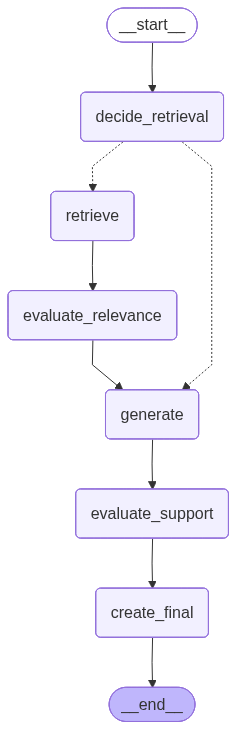

In [18]:
from IPython.display import Image, display

try:
    
    display(
        Image(
            self_rag_app.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")


## 7. Self-RAG 시스템 실행 함수

사용자가 쉽게 사용할 수 있는 실행 함수를 만듭니다.


### Self-RAG 시스템을 실행하는 메인 함수

In [8]:
def run_self_rag(question: str, verbose: bool = True):
    """Self-RAG 시스템을 실행하는 메인 함수"""
    
    print(f"질문: {question}")
    print("=" * 50)
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "need_retrieval": False,
        "retrieved_docs": [],
        "relevant_docs": [],
        "answer": "",
        "sources": [],
        "relevance_score": 0.0,
        "support_score": 0.0,
        "utility_score": 0.0,
        "final_answer": "",
        "confidence": "unknown"
    }
    
    # Self-RAG 워크플로우 실행
    try:
        result = self_rag_app.invoke(initial_state)
        
        if verbose:
            print("\n=== Self-RAG 실행 결과 ===")
            print(f"검색 필요성: {'필요' if result['need_retrieval'] else '불필요'}")
            print(f"검색된 문서 수: {len(result['retrieved_docs'])}")
            print(f"관련 문서 수: {len(result['relevant_docs'])}")
            print(f"관련성 점수: {result['relevance_score']:.2f}")
            print(f"지지도 점수: {result['support_score']:.2f}")
            print(f"신뢰도: {result['confidence']}")
            print(f"출처 수: {len(result['sources'])}")
            print("\n=== 최종 답변 ===")
        
        print(result["final_answer"])
        
        return result
        
    except Exception as e:
        error_message = f"Self-RAG 실행 중 오류가 발생했습니다: {str(e)}"
        print(error_message)
        return {"final_answer": "죄송하지만 시스템 오류로 인해 답변을 제공할 수 없습니다."}

print("Self-RAG 실행 함수 구현 완료!")


Self-RAG 실행 함수 구현 완료!


## 8. 테스트 예제

다양한 질문으로 Self-RAG 시스템을 테스트해봅니다.


### 테스트 1: 기술 용어에 대한 질문 (검색 필요)

In [17]:
# 테스트 1: 기술 용어에 대한 질문 (검색 필요)
print("테스트 1: 기술 용어 질문")
result1 = run_self_rag("Transformer가 무엇인가요?")
print("\n" + "="*80 + "\n")


테스트 1: 기술 용어 질문
질문: Transformer가 무엇인가요?
검색 필요성 판단: 필요
5개의 문서를 검색했습니다.
1개의 관련 문서를 선별했습니다. (평균 관련성: 5.00)
답변 생성 완료. 출처: 1개
지지도 평가: 5.0/5
최종 답변 생성 완료

=== Self-RAG 실행 결과 ===
검색 필요성: 필요
검색된 문서 수: 5
관련 문서 수: 1
관련성 점수: 5.00
지지도 점수: 5.00
신뢰도: medium
출처 수: 1

=== 최종 답변 ===
트랜스포머(Transformer)는 자연어 처리에서 사용되는 딥러닝 모델의 한 유형으로, 주로 번역, 요약, 텍스트 생성 등에 활용됩니다. 이 모델은 Attention 메커니즘을 기반으로 하며, 예를 들어 구글 번역기는 트랜스포머 모델을 사용하여 다양한 언어 간의 번역을 수행합니다.

**출처:**
1. 파일: rag-keywords.txt





### 테스트 2: 일반적인 인사말 (검색 불필요)

In [16]:
# 테스트 2: 일반적인 인사말 (검색 불필요)
print("테스트 2: 일반적인 인사말")
result2 = run_self_rag("안녕하세요!")
print("\n" + "="*80 + "\n")


테스트 2: 일반적인 인사말
질문: 안녕하세요!
검색 필요성 판단: 불필요
관련 문서가 없어 일반적인 답변을 생성합니다.

=== Self-RAG 실행 결과 ===
검색 필요성: 불필요
검색된 문서 수: 0
관련 문서 수: 0
관련성 점수: 0.00
지지도 점수: 0.00
신뢰도: unknown
출처 수: 0

=== 최종 답변 ===
안녕하세요! 어떻게 도와드릴까요?




### 테스트 3: 데이터베이스에 없는 내용 (모른다고 답변)

In [15]:
# 테스트 3: 데이터베이스에 없는 내용 (모른다고 답변)
print("테스트 3: 알 수 없는 질문")
result3 = run_self_rag("양자컴퓨터의 작동 원리는 무엇인가요?")
print("\n" + "="*80 + "\n")


테스트 3: 알 수 없는 질문
질문: 양자컴퓨터의 작동 원리는 무엇인가요?
검색 필요성 판단: 필요
5개의 문서를 검색했습니다.
0개의 관련 문서를 선별했습니다. (평균 관련성: 0.00)
관련 문서가 없어 일반적인 답변을 생성합니다.

=== Self-RAG 실행 결과 ===
검색 필요성: 필요
검색된 문서 수: 5
관련 문서 수: 0
관련성 점수: 0.00
지지도 점수: 0.00
신뢰도: unknown
출처 수: 0

=== 최종 답변 ===
죄송하지만 해당 질문에 대한 정확한 정보를 제공할 수 없습니다.




### 테스트 4: 복합적인 기술 질문 (검색 필요, 출처 표시)

In [14]:
# 테스트 4: 복합적인 기술 질문 (검색 필요, 출처 표시)
print("테스트 4: 복합적인 기술 질문")
result4 = run_self_rag("임베딩과 벡터스토어의 관계는 무엇인가요?")
print("\n" + "="*80 + "\n")


테스트 4: 복합적인 기술 질문
질문: 임베딩과 벡터스토어의 관계는 무엇인가요?
검색 필요성 판단: 필요
5개의 문서를 검색했습니다.
2개의 관련 문서를 선별했습니다. (평균 관련성: 4.50)
답변 생성 완료. 출처: 2개
지지도 평가: 5.0/5
최종 답변 생성 완료

=== Self-RAG 실행 결과 ===
검색 필요성: 필요
검색된 문서 수: 5
관련 문서 수: 2
관련성 점수: 4.50
지지도 점수: 5.00
신뢰도: high
출처 수: 2

=== 최종 답변 ===
임베딩과 벡터스토어의 관계는 임베딩이 텍스트 데이터를 저차원의 연속적인 벡터로 변환하는 과정이라는 점에서 시작됩니다. 이 과정에서 생성된 벡터는 벡터스토어에 저장됩니다. 벡터스토어는 이러한 벡터 형식으로 변환된 데이터를 저장하는 시스템으로, 검색, 분류 및 데이터 분석 작업에 활용됩니다. 따라서 임베딩은 벡터스토어에 저장될 데이터를 생성하는 역할을 하며, 벡터스토어는 이러한 임베딩된 데이터를 효율적으로 관리하고 접근할 수 있게 해줍니다.

**출처:**
1. 파일: rag-keywords.txt
2. 파일: rag-keywords.txt



